<a href="https://colab.research.google.com/github/weagan/Neuro-Symbolic/blob/main/Symbolic_vs_Neuro_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic AI vs. Neuro AI: A Pathfinding Comparison
This notebook demonstrates the fundamental difference between **Symbolic AI** (rule-based) and **Neuro AI** (pattern-based) using a maze-solving problem.

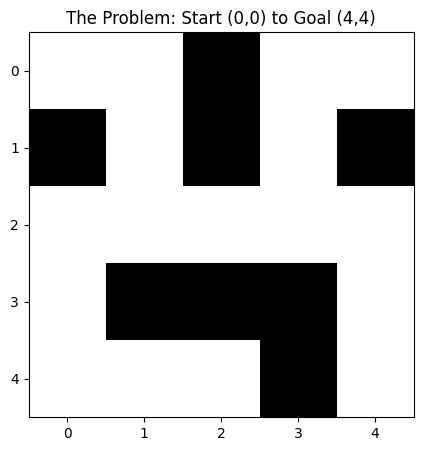

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# 1. Setup the Environment (The Maze)
# 0 = Path, 1 = Wall
maze = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0]
])

def plot_maze(path=None, title="Maze"):
    plt.figure(figsize=(5,5))
    plt.imshow(maze, cmap='binary')
    if path:
        y, x = zip(*path)
        plt.plot(x, y, color='red', marker='o', markersize=8, linewidth=2)
    plt.title(title)
    plt.show()

plot_maze(title="The Problem: Start (0,0) to Goal (4,4)")

## Part 1: Symbolic AI (Breadth-First Search)
Symbolic AI uses explicit logic. It searches through all possible states to find a path that satisfies the goal condition.

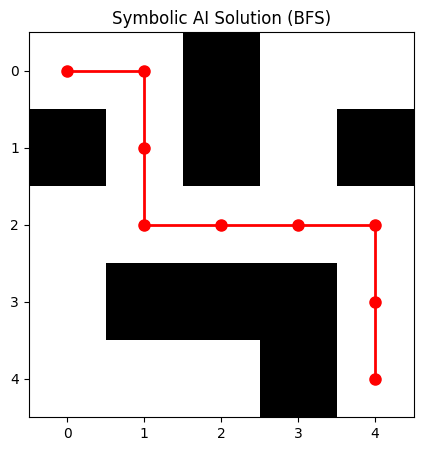

In [ ]:
def symbolic_solve(maze, start, goal):
    queue = deque([[start]])
    seen = {start}
    while queue:
        path = queue.popleft()
        y, x = path[-1]
        if (y, x) == goal:
            return path
        for dy, dx in [(0,1), (1,0), (0,-1), (-1,0)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < 5 and 0 <= nx < 5 and maze[ny][nx] == 0 and (ny, nx) not in seen:
                queue.append(path + [(ny, nx)])
                seen.add((ny, nx))
    return None

symbolic_path = symbolic_solve(maze, (0,0), (4,4))
plot_maze(symbolic_path, "Symbolic AI Solution (BFS)")

## Part 2: Neuro AI (Neural Network)
Neuro AI doesn't know the rules. It learns a mapping from a current position to the next step based on training data.

Training Neuro AI...


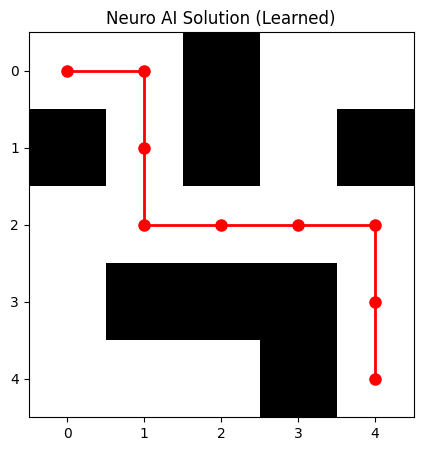

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# 1. Setup the Environment (The Maze)
# 0 = Path, 1 = Wall
maze = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0]
])

def plot_maze(path=None, title="Maze"):
    plt.figure(figsize=(5,5))
    plt.imshow(maze, cmap='binary')
    if path:
        y, x = zip(*path)
        plt.plot(x, y, color='red', marker='o', markersize=8, linewidth=2)
    plt.title(title)
    plt.show()

# Training data: (current_pos) -> (next_pos)
# Explicitly defined X_train and y_train based on the symbolic_path
X_train = torch.tensor([[0,0], [0,1], [1,1], [2,1], [2,2], [2,3], [2,4], [3,4]], dtype=torch.float32)
y_train = torch.tensor([[0,1], [1,1], [2,1], [2,2], [2,3], [2,4], [3,4], [4,4]], dtype=torch.float32)

class NeuroAI(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x): return self.net(x)

model = NeuroAI()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Initialize an empty dictionary to store weights and biases history for both layers
all_params_history = {
    'layer1_weights': [],
    'layer1_biases': [],
    'layer2_weights': [],
    'layer2_biases': []
}

# Initialize an empty list to store loss history
loss_history = []

print("Training Neuro AI...")
for epoch in range(500): # Consider increasing epochs to 1000 or more for better convergence
    optimizer.zero_grad()
    loss = criterion(model(X_train), y_train)
    loss.backward()
    optimizer.step()

    # Capture the state of the first linear layer's weights and biases
    all_params_history['layer1_weights'].append(model.net[0].weight.detach().cpu().numpy().copy())
    all_params_history['layer1_biases'].append(model.net[0].bias.detach().cpu().numpy().copy())

    # Capture the state of the second linear layer's weights and biases
    all_params_history['layer2_weights'].append(model.net[2].weight.detach().cpu().numpy().copy())
    all_params_history['layer2_biases'].append(model.net[2].bias.detach().cpu().numpy().copy())

    # Capture the training loss
    loss_history.append(loss.item())

# Inference (do-while equivalent)
current_pos = torch.tensor([0,0], dtype=torch.float32)
neuro_path = [(0,0)]
goal = (4,4) # Define the goal
max_inference_steps = 20 # Limit steps to prevent infinite loops, adjust as needed

# Loop until goal is reached or max_inference_steps is exceeded
while tuple(current_pos.numpy().astype(int)) != goal and len(neuro_path) < max_inference_steps:
    with torch.no_grad():
        next_step_tensor = model(current_pos)
        predicted_step_rounded = next_step_tensor.round() # Round for maze coordinates

        ny, nx = int(predicted_step_rounded[0].item()), int(predicted_step_rounded[1].item())

        # Check for invalid move (out of bounds or into a wall)
        if not (0 <= ny < maze.shape[0] and 0 <= nx < maze.shape[1] and maze[ny][nx] == 0):
            # If the predicted step is invalid, the path ends here.
            # We don't add this invalid step to neuro_path.
            break

        # Check if the predicted next step is the same as the current step to avoid infinite loops if stuck
        if tuple(predicted_step_rounded.numpy().astype(int)) == tuple(current_pos.numpy().astype(int)):
            break

        current_pos = predicted_step_rounded
        neuro_path.append(tuple(current_pos.numpy().astype(int)))

plot_maze(neuro_path, "Neuro AI Solution (Learned)")

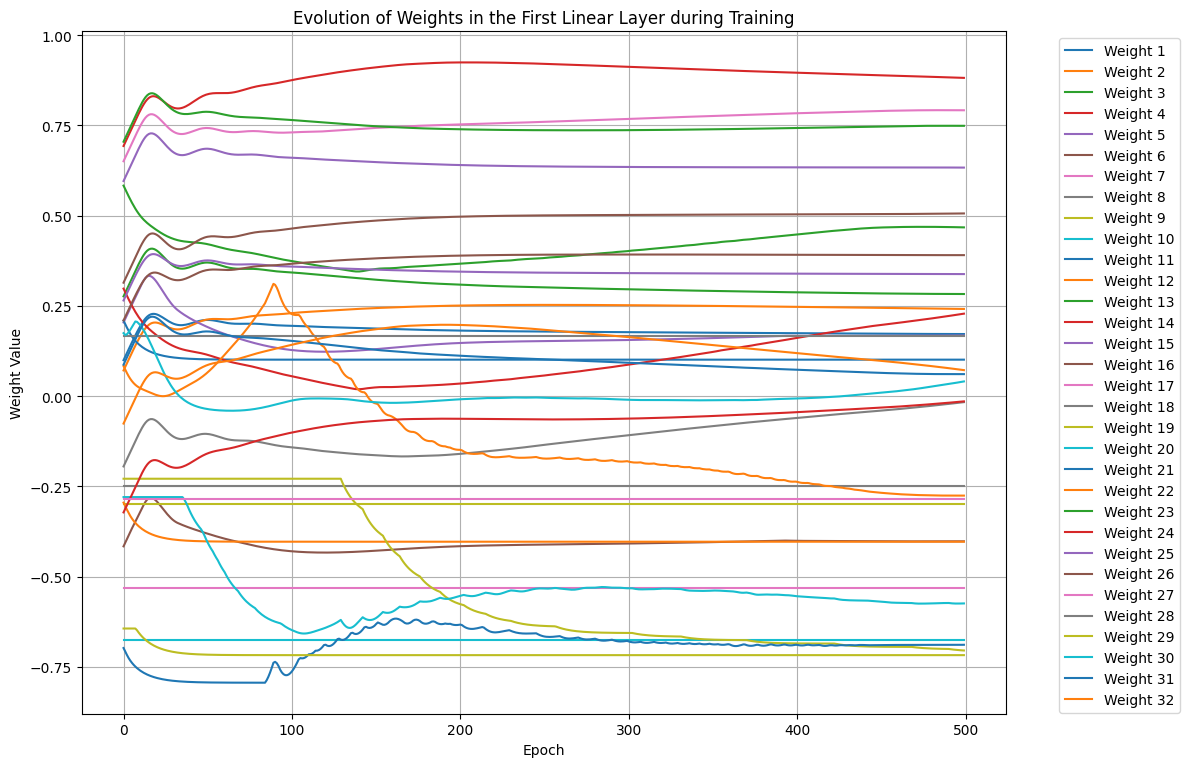

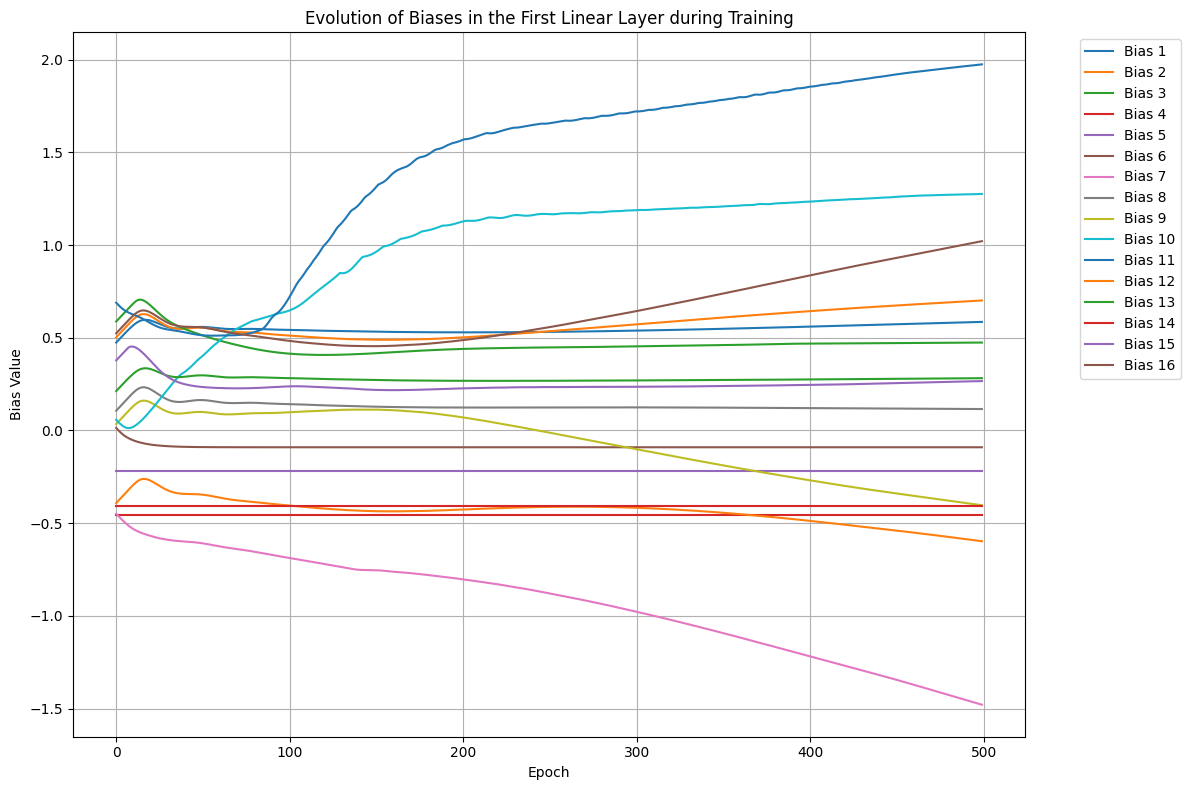

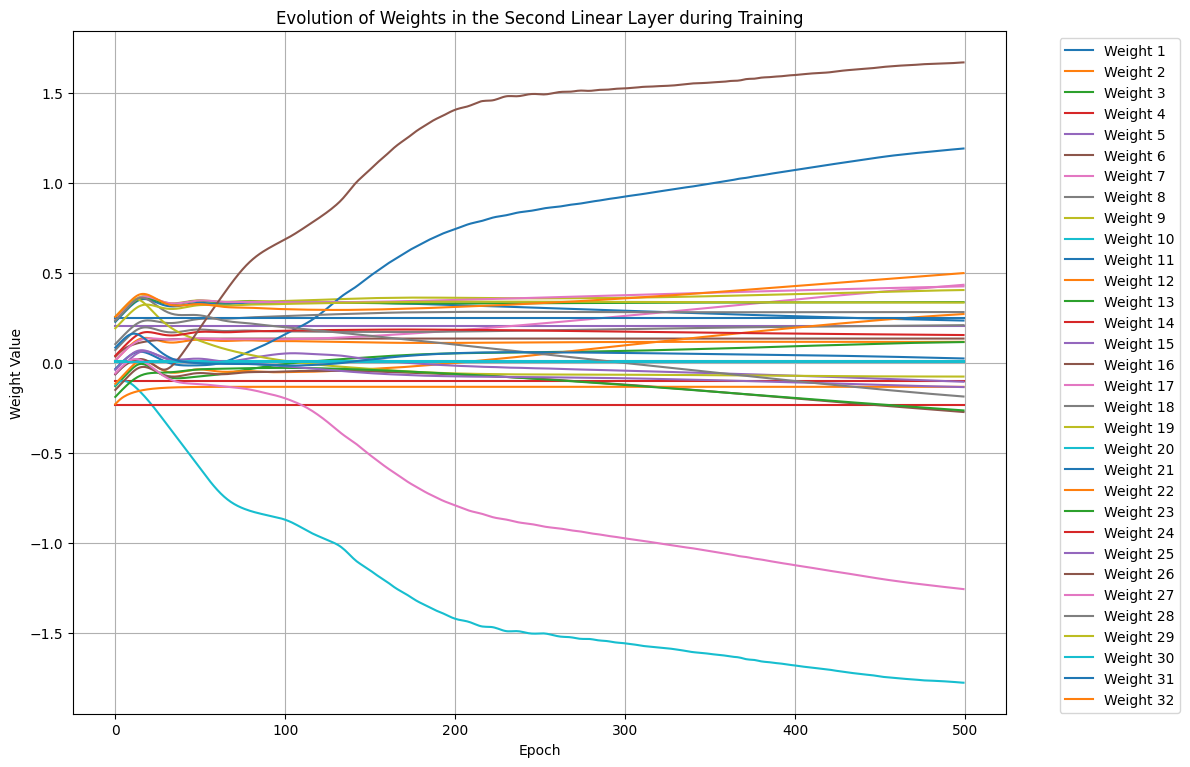

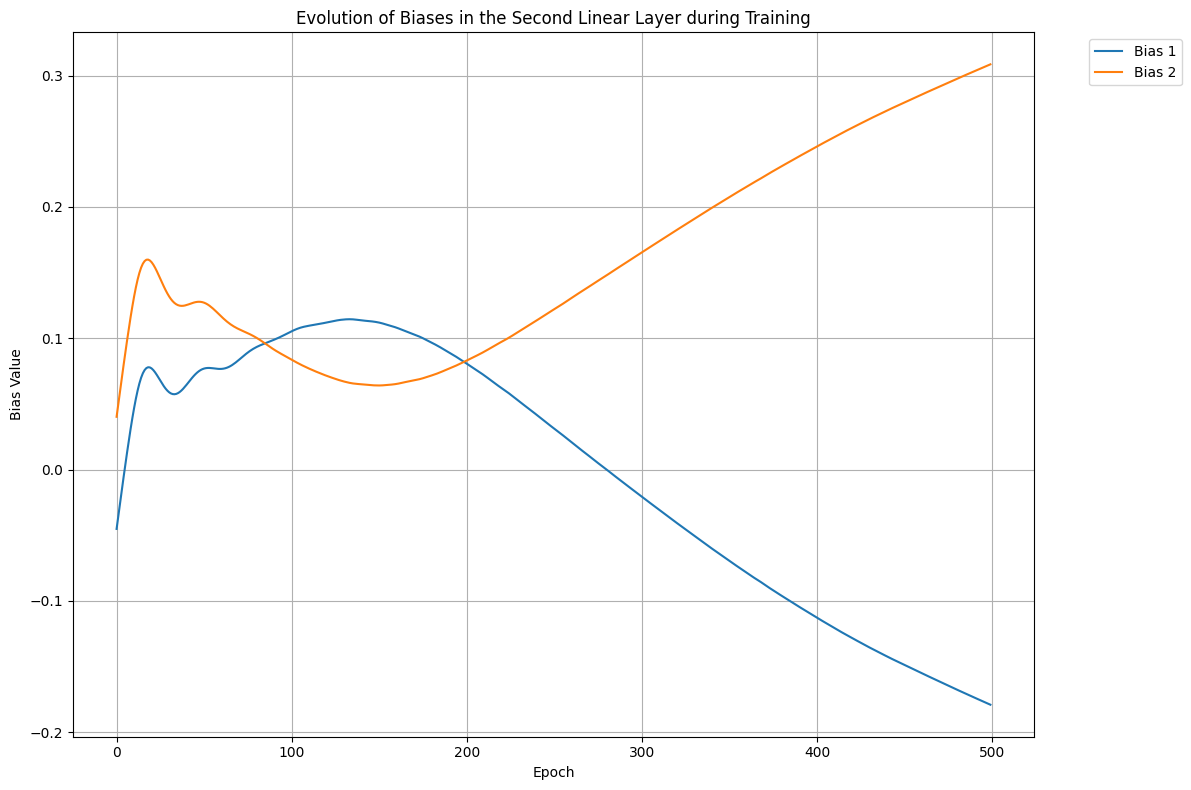

In [ ]:
def plot_parameter_evolution(param_history, title, param_type, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    if len(param_history) == 0:
        print(f"No data to plot for {title}")
        plt.close()
        return

    # Handle both 1D (biases) and 2D (weights) arrays for flattening
    num_params = param_history[0].size

    for i in range(num_params):
        # Extract the evolution of the i-th parameter across all epochs
        param_evolution = [epoch_params.flatten()[i] for epoch_params in param_history]
        plt.plot(param_evolution, label=f'{param_type.capitalize()} {i+1}')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(f'{param_type.capitalize()} Value')
    # Place legend outside the plot area for better readability
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize evolution for the first linear layer's weights
plot_parameter_evolution(all_params_history['layer1_weights'], 'Evolution of Weights in the First Linear Layer during Training', 'weight')

# Visualize evolution for the first linear layer's biases
plot_parameter_evolution(all_params_history['layer1_biases'], 'Evolution of Biases in the First Linear Layer during Training', 'bias')

# Visualize evolution for the second linear layer's weights
plot_parameter_evolution(all_params_history['layer2_weights'], 'Evolution of Weights in the Second Linear Layer during Training', 'weight')

# Visualize evolution for the second linear layer's biases
plot_parameter_evolution(all_params_history['layer2_biases'], 'Evolution of Biases in the Second Linear Layer during Training', 'bias')

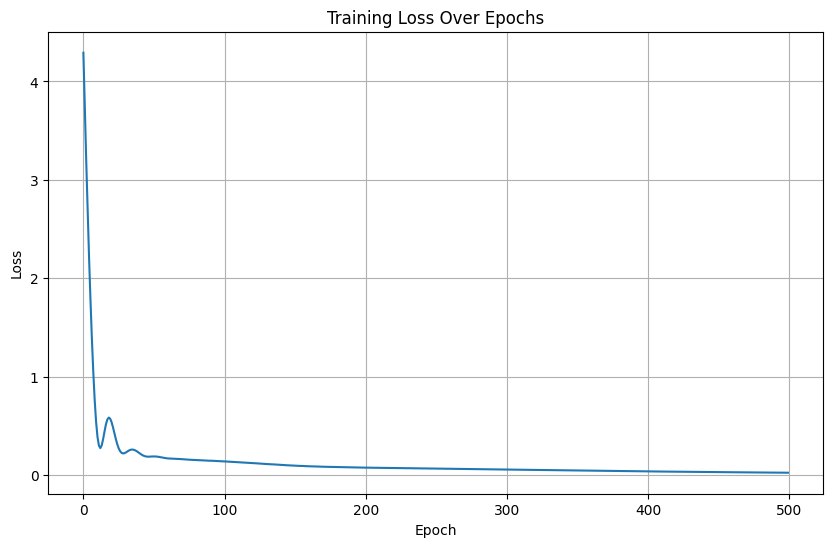

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in NeuroAI model: {total_params}")

Total number of trainable parameters in NeuroAI model: 82


**you say that Symbolic AI has "rules" but Neuro AI does not. by rules do you mean algorithms?**

That is a great question that touches on the core "philosophy" of computer science. While both involve algorithms, they use them in fundamentally different ways.

In short: **Symbolic AI *is* an algorithm. Neuro AI *uses* an algorithm to find a solution.**

---

### 1. Symbolic AI: The Algorithm is the Solution

In Symbolic AI, the "rules" are the explicit instructions provided by a human. If you are solving a maze, the rules are: *"If there is a wall at (x,y), do not move there. If you are at (0,0), explore adjacent cells until you hit the goal."*

* **The "Rules":** These are hard-coded logic statements (If-Then-Else).
* **The Algorithm:** A human-designed search process (like Breadth-First Search) that follows those rules step-by-step.
* **Transparency:** You can look at the code and see exactly why the AI decided to turn left at a specific coordinate.

### 2. Neuro AI: The Algorithm is the Teacher

In Neuro AI, the "rules" aren't written by humans; they are "emergent." The AI starts as a blank slate of random mathematical weights. We use an algorithm (like **Backpropagation**) to adjust those weights until the network happens to output the right answer.

* **The "Rules":** There are no explicit rules like "don't hit walls." Instead, there are millions of tiny numbers (weights) that, when multiplied together, result in a path.
* **The Algorithm:** The algorithm (Gradient Descent) is used only during the **training** phase to "sculpt" the weights. Once trained, the AI doesn't "think"—it just flows data through a mathematical function.
* **The "Black Box":** If you look at the weights of a neural network, you won't see a rule saying "turn left." You will just see a massive table of decimals.

---

### Summary Table

| Feature | Symbolic AI | Neuro AI |
| --- | --- | --- |
| **Logic Source** | Human-coded logic symbols. | Statistical patterns in data. |
| **"The Rules"** | Explicit (e.g., `if wall == True: stop`). | Implicit (encoded in matrix weights). |
| **Role of Algorithm** | To execute the logic directly. | To train the system to find its own logic. |
| **Analogy** | Following a recipe exactly. | Learning to cook by tasting and failing. |

---

### A Note on the "Gray Area"

To be precise, **Symbolic AI is transparent logic**, while **Neuro AI is non-linear regression**. When we say Neuro AI "doesn't have rules," we mean it doesn't have *human-readable* rules. It operates on high-dimensional calculus rather than "If-Then" logic.

Would you like to see how the code for the **Backpropagation algorithm** (the "teacher") looks compared to the **Search algorithm** (the "logic") in the notebook?